In [ ]:
#######################  STEP1:EDA #######################

In [1]:
import pandas as pd
#df = pd.read_csv('NYC_taxi.csv', parse_dates=['pickup_datetime'], nrows=500000)
df = pd.read_csv('NYC_taxi_sample.csv', parse_dates=['pickup_datetime'])

In [2]:
#df.to_csv("NYC_taxi_sample.csv",index = False)
df.head()
# key: This column seems identical to the pickup_datetime column. It was probably used as an unique identifier in the database it was stored in. We can safely remove this column without any loss of information.
# fare_amount: This is the target variable we are trying to predict, the fare amount paid at the end of the trip.
# pickup_datetime: This column contains information on the pickup date (year, month, day of month), as well as the time (hour, minute, seconds).
# pickup_longitude and pickup_latitude: The longitude and latitude of the pickup location.
# dropoff_longitude and dropoff_latitude: The longitude and latitude of the drop off location.
# passenger_count: The number of passengers. 

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
df.shape

(500000, 8)

In [96]:
#Visualizing geolocation data
#First, let's restrict our data points to only pickups and drop offs within NYC. NYC has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] <
                                                 nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] < 
                                               nyc_max_latitude)]

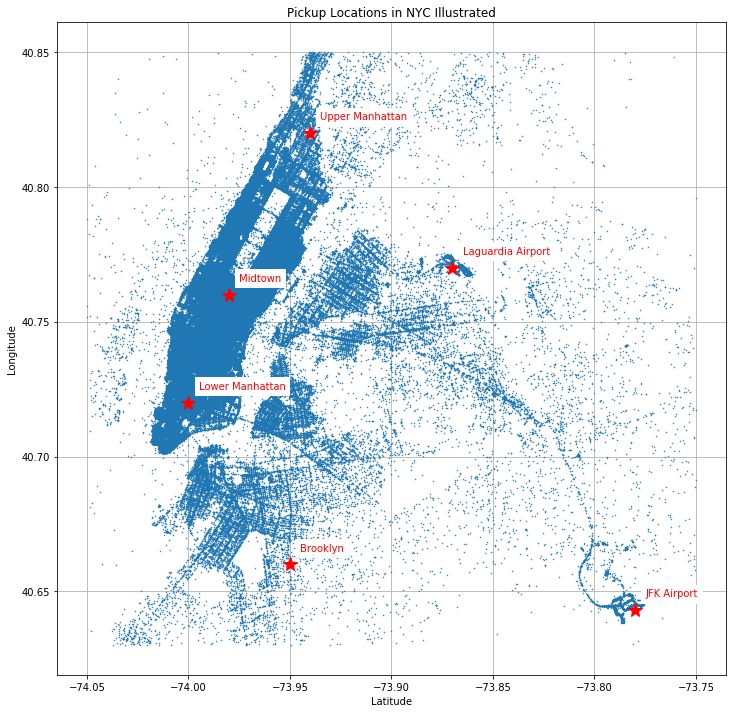

In [97]:
#Now, let's define a new function that will take our DataFrame as an input, and plot the pickup locations on a scatterplot. 
#We are also interested in overlaying the scatterplot with a few key landmarks in NYC
landmarks = {'JFK Airport': (-73.78, 40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)}

import matplotlib.pyplot as plt

def plot_lat_long(df, landmarks, points='Pickup'):
    plt.figure(figsize = (12,12)) # set figure size
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), 
                 '.', markersize=1)
    else:
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), 
                 '.', markersize=1)

    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], 
                '*', markersize=15, alpha=1, color='r') 
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, 
                     landmarks[landmark][1]+0.005), color='r', 
                     backgroundcolor='w') 

    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()
plot_lat_long(df2, landmarks, points='Pickup')
#Observations
#In Manhattan, most pickups were around the Midtown area, followed by Lower Manhattan. 
#Pickups are sparse outside Manhattan. The only two outliers were at LaGuardia Airport and JFK Airport.

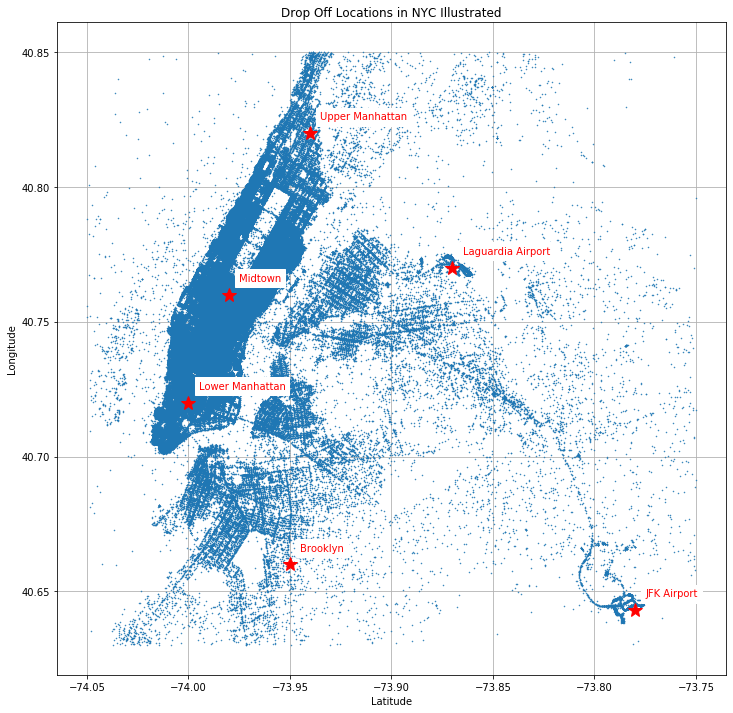

In [98]:
#Plot the scatterplot for drop off locations:
plot_lat_long(df2, landmarks, points='Drop Off')
#Observations
#more drop offs than pickups in residential areas such as Upper Manhattan and Brooklyn

In [99]:
#Ridership by day and hour
df2['year'] = df2['pickup_datetime'].dt.year
df2['month'] = df2['pickup_datetime'].dt.month
df2['day'] = df2['pickup_datetime'].dt.day
df2['day_of_week'] = df2['pickup_datetime'].dt.dayofweek
df2['hour'] = df2['pickup_datetime'].dt.hour

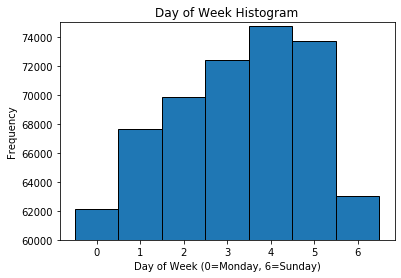

In [100]:
#plot a histogram to analyze the distribution of rides throughout the week
import numpy as np
df2['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black', 
                            ylim=(60000,75000))
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.title('Day of Week Histogram')
plt.show()
#Observations
#Number of rides increases linearly from Monday through Friday, and peaking on Friday.
#The weekends see a slight drop in the number of rides on Saturday, before falling sharply on Sunday

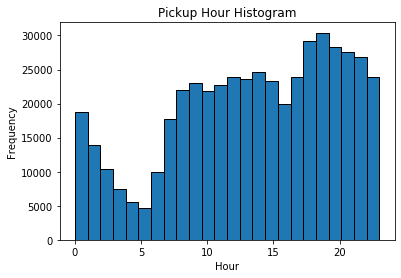

In [101]:
#visualize ridership by hour:
df2['hour'].plot.hist(bins=24, ec='black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')
plt.show()
#Observations
#More rides during the evening rush hour, as compared to the morning rush hour

In [ ]:
#######################  STEP2:Data preprocessing #######################

In [102]:
# 1. Remove missing values since constitute 0.001% of the dataset.
# 2. Remove the outliers for the fare_amount(0-100), latitude and longitude. 
# 3. Replace 0 passenger count with the passenger count mode (1).

def preprocess(df): 
    # remove missing values in the dataframe
    def remove_missing_values(df):
        df = df.dropna()
        return df

    # remove outliers in fare amount
    def remove_fare_amount_outliers(df, lower_bound, upper_bound):
        df = df[(df['fare_amount'] >= lower_bound) & 
                (df['fare_amount'] <= upper_bound)]
        return df

    # replace outliers in passenger count with the mode
    def replace_passenger_count_outliers(df):
        mode = df['passenger_count'].mode()
        df.loc[df['passenger_count'] == 0, 'passenger_count'] = mode
        return df

    # remove outliers in latitude and longitude
    def remove_lat_long_outliers(df):
        # range of longitude for NYC
        nyc_min_longitude = -74.05
        nyc_max_longitude = -73.75
        # range of latitude for NYC
        nyc_min_latitude = 40.63
        nyc_max_latitude = 40.85
        # only consider locations within New York City
        for long in ['pickup_longitude', 'dropoff_longitude']:
            df = df[(df[long] > nyc_min_longitude) & 
                    (df[long] < nyc_max_longitude)]
        for lat in ['pickup_latitude', 'dropoff_latitude']:
            df = df[(df[lat] > nyc_min_latitude) & 
                    (df[lat] < nyc_max_latitude)]
        return df

    df = remove_missing_values(df)
    df = remove_fare_amount_outliers(df, lower_bound = 0, 
                                     upper_bound = 100)
    df = replace_passenger_count_outliers(df)
    df = remove_lat_long_outliers(df)
    return df

df_preprocessed =preprocess(df)
df_preprocessed.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,483438.000000,483438.000000,483438.000000,483438.000000,483438.000000,481706.000000
mean,11.014298,-73.975684,40.750901,-73.974589,40.751156,1.689578
std,8.771064,0.033540,0.026220,0.032035,0.028471,1.305778
min,0.000000,-74.049288,40.630097,-74.049897,40.630056,1.000000
25%,6.000000,-73.992263,40.736642,-73.991547,40.735920,1.000000
50%,8.500000,-73.982097,40.753380,-73.980677,40.753855,1.000000
75%,12.500000,-73.968485,40.767395,-73.965803,40.768243,2.000000
max,100.000000,-73.750322,40.849922,-73.750061,40.849988,6.000000


In [108]:
#Feature engineering
# 1. Create temporal features
def feature_engineer(df):
    # create new columns for year, month, day, day of week and hour
    def create_time_features(df):
        df['year'] = df['pickup_datetime'].dt.year
        df['month'] = df['pickup_datetime'].dt.month
        df['day'] = df['pickup_datetime'].dt.day
        df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
        df['hour'] = df['pickup_datetime'].dt.hour
        df = df.drop(['pickup_datetime'], axis=1)
        return df

    # function to calculate euclidean distance
    def euc_distance(lat1, long1, lat2, long2):
        return(((lat1-lat2)**2 + (long1-long2)**2)**0.5)

    # create new column for the distance travelled
    def create_pickup_dropoff_dist_features(df):
        df['travel_distance'] = euc_distance(df['pickup_latitude'], 
                                             df['pickup_longitude'], 
                                             df['dropoff_latitude'],
                                             df['dropoff_longitude'])
        return df

    # create new column for the distance away from airports
    def create_airport_dist_features(df):
        airports = {'JFK_Airport': (-73.78,40.643),
                    'Laguardia_Airport': (-73.87, 40.77),
                    'Newark_Airport' : (-74.18, 40.69)}
        for k in airports:
            df['pickup_dist_'+k]=euc_distance(df['pickup_latitude'], 
                                              df['pickup_longitude'],
                                              airports[k][1],
                                              airports[k][0])
            df['dropoff_dist_'+k]=euc_distance(df['dropoff_latitude'], 
                                               df['dropoff_longitude'],
                                               airports[k][1],
                                               airports[k][0]) 
        return df

    df = create_time_features(df)
    df = create_pickup_dropoff_dist_features(df)
    df = create_airport_dist_features(df)
    df = df.drop(['key'], axis=1)
    return df

df_preprocessed2= feature_engineer(df_preprocessed)
df_preprocessed2.shape

(483438, 18)

In [110]:
#Feature scaling
df_prescaled = df_preprocessed2.copy()
# Remove fare_amount target variable before scaling
df_scaled = df_preprocessed2.drop(['fare_amount'], axis=1)
from sklearn.preprocessing import scale
df_scaled = scale(df_scaled)
cols = df_preprocessed2.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df_preprocessed2.index)
df_scaled = pd.concat([df_scaled, df_preprocessed2['fare_amount']], axis=1)
df_scaled_final = df_scaled.dropna()
df_scaled_final.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,travel_distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport,fare_amount
count,481706.000000,481706.000000,481706.000000,481706.000000,4.817060e+05,481706.000000,481706.000000,481706.000000,4.817060e+05,481706.000000,481706.000000,481706.000000,481706.000000,481706.000000,481706.000000,481706.000000,481706.000000,481706.000000
mean,0.000256,-0.000145,0.000174,-0.000065,-4.838180e-18,0.000730,0.000549,-0.000115,7.196551e-07,-0.000053,0.000521,-0.000267,-0.000186,-0.000169,-0.000160,0.000219,0.000147,11.022558
std,1.000536,1.000139,1.000254,1.000029,1.000001e+00,1.001565,0.999860,0.999996,1.000009e+00,1.000105,1.000738,1.000500,1.000234,1.000542,1.000292,1.000468,1.000204,8.779261
min,-2.194519,-4.607342,-2.350829,-4.253451,-5.280982e-01,-1.469611,-1.531625,-1.690959,-1.560801e+00,-2.083145,-0.906781,-7.150829,-7.799392,-4.516731,-4.467844,-2.326521,-2.469679,0.000000
25%,-0.494311,-0.543863,-0.529297,-0.535186,-5.280982e-01,-0.932852,-0.950250,-0.884589,-1.047515e+00,-0.696834,-0.554147,-0.094612,-0.120817,-0.449037,-0.475288,-0.563997,-0.594784,6.000000
50%,-0.191211,0.094472,-0.190038,0.094822,-5.280982e-01,0.140667,-0.078187,0.036977,-2.094493e-02,0.073338,-0.309833,0.145817,0.155086,0.074890,0.053447,-0.166550,-0.159742,8.500000
75%,0.214685,0.628990,0.274304,0.600107,2.377296e-01,0.677426,0.793875,0.843347,1.005625e+00,0.843511,0.142476,0.429543,0.484315,0.590658,0.596474,0.311389,0.378440,12.500000
max,6.719190,3.776563,7.008934,3.471302,3.301041e+00,1.750944,1.665938,1.764913,1.518911e+00,1.459649,6.706497,3.415395,3.394495,3.799675,4.460496,6.576179,6.814246,100.000000


In [111]:
#split the dataset into the training features (X) and the target variable (y):
X = df_scaled_final.loc[:, df_scaled_final.columns != 'fare_amount'] 
y = df_scaled_final.loc[:, 'fare_amount']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#######################  STEP3:Model creation  #######################

In [112]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation= 'relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(8, activation= 'relu'))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               2304      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 12,913
Trainable params: 12,913
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs=1)

Epoch 1/1
385364/385364 [==============================] - 42s 109us/step - loss: 11.6506 - mean_squared_error: 11.6506


In [ ]:
#######################  STEP4: Results analysis  #######################

In [120]:
#create a function to make a prediction using a random sample from the testing set:
def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0, 
                                                              high=10000))
    idx = sample.index[0]

    actual_fare = df_prescaled.loc[idx,'fare_amount']
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                 'Saturday', 'Sunday']
    day_of_week = day_names[df_prescaled.loc[idx,'day_of_week']]
    hour = df_prescaled.loc[idx,'hour']
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare-actual_fare))

    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour))  
    print("Actual fare: ${:0.2f}".format(actual_fare))
    print("Predicted fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

predict_random(df_prescaled, X_test, model)

Trip Details: Monday, 8:00hrs
Actual fare: $5.70
Predicted fare: $5.91
RMSE: $0.21


In [121]:
predict_random(df_prescaled, X_test, model)

Trip Details: Tuesday, 0:00hrs
Actual fare: $6.50
Predicted fare: $7.24
RMSE: $0.74


In [122]:
predict_random(df_prescaled, X_test, model)

Trip Details: Friday, 15:00hrs
Actual fare: $7.50
Predicted fare: $8.45
RMSE: $0.95


In [123]:
# Calculating the RMSE for the entire training and testing set:
from sklearn.metrics import mean_squared_error

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))

Train RMSE: 3.43
Test RMSE: 3.53
